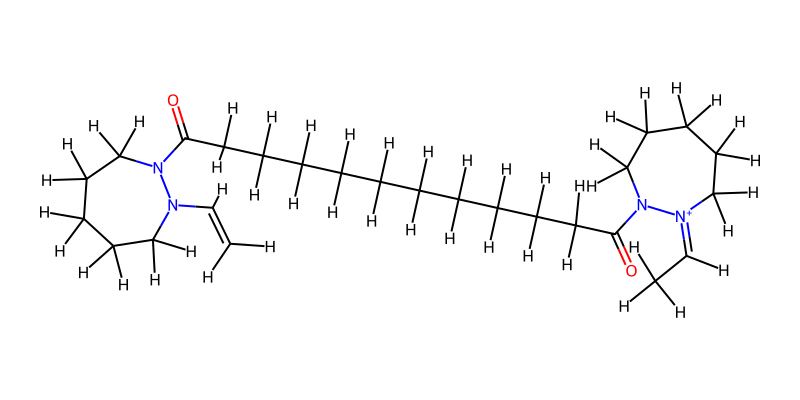

In [2]:
import datamol as dm 
from rdkit import Chem
from rdkit.Chem import Draw  

# Generate mol from SMILES, add H
smiles = "O=C(N1N(C=C)CCCCC1)CCCCCCCCCCC(N2CCCCC/[N+]2=C/C)=O"
mol = dm.to_mol(smiles)
mol = dm.add_hs(mol)
Draw.MolToImage(mol, size=(800,400))

In [3]:
# Use datamol to generate and minimize (with MMFF94s forcefield) conformers. Align all conformers. No max E; keep all conformers. Many other parameters are available (see datamol)
conf = dm.conformers.generate(mol, n_confs=20, num_threads=10, align_conformers=True, forcefield='MMFF94s', minimize_energy=True, add_hs=False, random_seed=1)


In [4]:
import py3Dmol

# Display first conformer to confirm structure.
viewer = py3Dmol.view(width=800, height=600)
mb = Chem.MolToMolBlock(conf)
viewer.addModel(mb, 'mol')
viewer.setStyle({'stick': {}})
viewer.zoomTo()
viewer.show()



3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [6]:
# Export summary.txt and outpt.csv of key parameters from generated conformers. 
# Output .xyz file for each conformer in new output directory. 
import os
import csv
from rdkit import Chem

# Create the output directory
output_dir = "output_xyz"
os.makedirs(output_dir, exist_ok=True)

# calculate dihedral angle
def calculate_dihedral(mol, idx1, idx2, idx3, idx4, confId):
    conf = mol.GetConformer(confId)
    pos1 = conf.GetAtomPosition(idx1)
    pos2 = conf.GetAtomPosition(idx2)
    pos3 = conf.GetAtomPosition(idx3)
    pos4 = conf.GetAtomPosition(idx4)
    return Chem.rdMolTransforms.GetDihedralDeg(conf, idx1, idx2, idx3, idx4)

# Write all conformers to .xyz files and create summary txt file with key info. Write .csv file with distances
def write_conformers_to_xyz_and_summary(mol, base_filename="conf"):
    energies = []
    distances_5_29 = []
    distances_1_21 = []
    dihedrals = []
    for i, conf in enumerate(mol.GetConformers()):
        filename = os.path.join(output_dir, f"{base_filename}_{i+1}.xyz")
        with open(filename, 'w') as f:
            f.write(f"{mol.GetNumAtoms()}\n")
            f.write(f"conformer {i+1}\n")
            for atom in mol.GetAtoms():
                pos = conf.GetAtomPosition(atom.GetIdx())
                f.write(f"{atom.GetSymbol()} {pos.x:.4f} {pos.y:.4f} {pos.z:.4f}\n")
        
        # Retrieve energy from conformer properties
        energy = conf.GetProp("rdkit_MMFF94s_energy")
        energies.append((i+1, float(energy)))

        # Calculate distance between atoms 5 and 29
        atom_5_pos = conf.GetAtomPosition(5)
        atom_29_pos = conf.GetAtomPosition(29)
        distance_5_29 = atom_5_pos.Distance(atom_29_pos)
        distances_5_29.append((i+1, distance_5_29))

        # Calculate distance between atoms 1 and 21
        atom_1_pos = conf.GetAtomPosition(1)
        atom_21_pos = conf.GetAtomPosition(21)
        distance_1_21 = atom_1_pos.Distance(atom_21_pos)
        distances_1_21.append((i+1, distance_1_21))

        # Calculate dihedral angles for each conformer
        dihedral_2_3_4_5 = calculate_dihedral(mol, 2, 3, 4, 5, i)
        dihedral_22_28_29_30 = calculate_dihedral(mol, 22, 28, 29, 30, i)
        dihedral_0_1_2_3 = calculate_dihedral(mol, 0, 1, 2, 3, i)
        dihedral_31_21_22_28 = calculate_dihedral(mol, 31, 21, 22, 28, i)
        dihedrals.append((i+1, dihedral_2_3_4_5, dihedral_22_28_29_30, dihedral_0_1_2_3, dihedral_31_21_22_28))
    
    # Calculate min and max energies
    min_energy = min(energies, key=lambda x: x[1])[1]
    max_energy = max(energies, key=lambda x: x[1])[1]

    # Calculate min and max distances for atoms 5 and 29
    min_dist_5_29 = min(distances_5_29, key=lambda x: x[1])[1]
    max_dist_5_29 = max(distances_5_29, key=lambda x: x[1])[1]

    # Calculate min and max distances for atoms 1 and 21
    min_dist_1_21 = min(distances_1_21, key=lambda x: x[1])[1]
    max_dist_1_21 = max(distances_1_21, key=lambda x: x[1])[1]

    # Write summary txt file with absolute energies and additional data
    with open(f"{base_filename}_summary.txt", 'w') as summary_file:
        summary_file.write("Conformer Energies (kcal/mol)\n")
        summary_file.write("==================\n")
        summary_file.write(f"Total number of conformers: {len(energies)}\n\n")
        summary_file.write(f"Minimum MMFF94s energy: {min_energy:.4f}\n")
        summary_file.write(f"Maximum MMFF94s energy: {max_energy:.4f}\n\n")
        summary_file.write(f"Minimum rel energy: {min_energy - min_energy:.4f}\n")
        summary_file.write(f"Maximum rel energy: {max_energy - min_energy:.4f}\n\n")
        summary_file.write(f"Minimum distance between atoms 5 and 29 (Å): {min_dist_5_29:.4f}\n")
        summary_file.write(f"Maximum distance between atoms 5 and 29 (Å): {max_dist_5_29:.4f}\n\n")
        summary_file.write(f"Minimum distance between atoms 1 and 21 (Å): {min_dist_1_21:.4f}\n")
        summary_file.write(f"Maximum distance between atoms 1 and 21 (Å): {max_dist_1_21:.4f}\n\n")
    
    # Output absolute energies, rel energies, and distances between atoms
    with open(f"output.csv", 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(["Conformer #", "MMFF94s Energy (kcal/mol)", "Rel Energy (kcal/mol)", "Atom 5 and 29 Distance (Å)", "Atom 1 and 21 Distance (Å)", "dihedral 2-3-4-5 (°)", "dihedral 22-28-29-30 (°)", "dihedral 0-1-2-3 (°)", "dihedral 31-21-22-28 (°)"])
        for (conf_id, energy), (_, distance_5_29), (_, distance_1_21), (_, dihedral_2_3_4_5, dihedral_22_28_29_30, dihedral_0_1_2_3, dihedral_31_21_22_28) in zip(energies, distances_5_29, distances_1_21, dihedrals):
            relative_energy = energy - min_energy
            csv_writer.writerow([conf_id, f"{energy:.4f}", f"{relative_energy:.4f}", f"{distance_5_29:.4f}", f"{distance_1_21:.4f}", f"{dihedral_2_3_4_5:.2f}", f"{dihedral_22_28_29_30:.2f}", f"{dihedral_0_1_2_3:.2f}", f"{dihedral_31_21_22_28:.2f}"])

# Example usage
write_conformers_to_xyz_and_summary(conf)